In [1]:
!pip install "tensorflow<2.11"

In [2]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        print("Using GPU:", gpus[0])
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found.")


Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [1]:
import os
import pandas as pd
PATH_DATA = "data"

images = []
labels = []

for subfolder in os.listdir(PATH_DATA):
    
    subfolder_path = os.path.join(PATH_DATA, subfolder)
    if not os.path.isdir(subfolder_path):
        continue
  
    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
    
        labels.append(subfolder)
 
df = pd.DataFrame({'image': images, 'label': labels})

In [3]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

strat1 = df['label']
train_df, dummy_df = train_test_split(df,  train_size= 0.81, shuffle= True, random_state= 123, stratify= strat1)

strat2 = dummy_df['label']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat2)


tr_gen = tf.keras.preprocessing.image.ImageDataGenerator()
ts_gen = tf.keras.preprocessing.image.ImageDataGenerator()


train_ds = tr_gen.flow_from_dataframe(train_df, x_col='image', y_col='label', target_size=IMG_SIZE, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=BATCH_SIZE)

valid_ds = ts_gen.flow_from_dataframe(valid_df, x_col='image', y_col='label', target_size=IMG_SIZE, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=BATCH_SIZE)

test_ds = ts_gen.flow_from_dataframe(test_df, x_col='image', y_col='label', target_size=IMG_SIZE, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=BATCH_SIZE)

Found 3839 validated image filenames belonging to 4 classes.
Found 450 validated image filenames belonging to 4 classes.
Found 451 validated image filenames belonging to 4 classes.


In [5]:
# Normalization
label_mapping = {
    'Gray_Leaf_Spot': 0,
    'Healthy': 1,
    'Leaf_Blight': 2,
    'Rust': 3
}

def preprocess_row(row):
    # Read and decode the image
    image = tf.io.read_file(row['image'])
    image = tf.image.decode_jpeg(image, channels=3)  # Decode as RGB
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]

    # Convert the label to integer type
    label = tf.strings.to_number(row['label'], out_type=tf.int32)  # Convert string labels to integers
    label = tf.one_hot(label, depth=4)  # Assuming 4 classes

    return image, label

# All Augmentation
def augmentation():
    augmentation_img = tf.keras.preprocessing.image.ImageDataGenerator( 
        rotation_range=30, 
        width_shift_range=0.1, 
        height_shift_range=0.1, 
        shear_range=0.2, 
        zoom_range=0.2, 
        horizontal_flip=True, 
        fill_mode='nearest' 
        ) 
    return augmentation_img

In [6]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping


model_dir = 'model'

class CustomCallback(Callback):
    def __init__(self, validation_data):
        super(CustomCallback, self).__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_loss = logs.get('val_loss', None)
        val_accuracy = logs.get('val_accuracy', None)

        # Contoh: Menyimpan metrik validasi ke file
        with open("training_log.txt", "a") as f:
            f.write(f"Epoch {epoch + 1}: Validation Loss = {val_loss:.4f}, Validation Accuracy = {val_accuracy:.4f}\n")

        # Tambahan: Bisa menghentikan pelatihan jika suatu kondisi terpenuhi
        if val_accuracy and val_accuracy > 0.98:
            print("Validation accuracy exceeded 98%. Stopping training!")
            self.model.stop_training = True


checkpoint = ModelCheckpoint(
    
    filepath=os.path.join(model_dir, 'best_model.keras'),  # Simpan model terbaik
    monitor='val_accuracy',        # Berdasarkan akurasi validasi
    save_best_only=True,           # Hanya menyimpan model terbaik
    mode='max',                    # Mencari nilai maksimum akurasi
    verbose=1
)

earlystop = EarlyStopping(
    monitor='val_loss',         # Metode evaluasi yang dimonitor (val_loss atau val_accuracy)
    patience=10,                 # Jumlah epoch tanpa perbaikan sebelum menghentikan pelatihan
    verbose=1,                  # Menampilkan informasi saat pelatihan dihentikan
    restore_best_weights=True   # Mengembalikan bobot model ke yang terbaik pada akhir pelatihan
)

In [7]:
import os

file_path = 'model/best_model.keras'

if os.path.exists(file_path):
    os.remove(file_path)
    print(f"File '{file_path}' telah dihapus.")
else:
    print(f"File '{file_path}' tidak ditemukan.")

custom_callback = CustomCallback(validation_data=valid_ds)

# Gabungkan dengan callback lain
callbacks = [checkpoint, custom_callback, earlystop]


File 'model/best_model.keras' tidak ditemukan.


In [8]:
# # Optimalisasi
# AUTOTUNE = tf.data.AUTOTUNE

# # Membuat Dataset dari DataFrame
# train_ds = tf.data.Dataset.from_tensor_slices(dict(train_df)).map(lambda x: preprocess_row(x), num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
# valid_ds = tf.data.Dataset.from_tensor_slices(dict(valid_df)).map(lambda x: preprocess_row(x), num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
# test_ds = tf.data.Dataset.from_tensor_slices(dict(test_df)).map(lambda x: preprocess_row(x), num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [9]:
# print(train_ds)

In [10]:
# batch_size = 32
# img_shape = (224, 224, 3)

# train_gen = augmentation()
# test_gen = augmentation()

# train_gen = train_gen.flow_from_dataframe(train_df, x_col='image', y_col='label', target_size=(224, 224), class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

# valid_gen = test_gen.flow_from_dataframe(valid_df, x_col='image', y_col='label', target_size=(224, 224), class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

# test_gen = test_gen.flow_from_dataframe(test_df, x_col='image', y_col='label', target_size=(224, 224), class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

In [11]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Mengambil informasi kelas dari generator
# g_dict = train_gen.class_indices
# classes = list(g_dict.keys())

# # Mengambil batch pertama dari generator
# images, labels = next(train_gen)

# # Membuat figur
# plt.figure(figsize=(12, 12))

# # Looping untuk menampilkan gambar dalam grid 4x4
# for i in range(16):
#     plt.subplot(4, 4, i + 1)  # Grid 4x4
#     image = images[i] / 255  # Normalisasi gambar
#     plt.imshow(image)        # Menampilkan gambar

#     # Mendapatkan nama kelas berdasarkan label one-hot
#     index = np.argmax(labels[i])
#     class_name = classes[index]

#     # Menambahkan judul
#     plt.title(class_name, color='blue', fontsize=10)
#     plt.axis('off')  # Menyembunyikan sumbu

# # Menampilkan semua gambar
# plt.tight_layout()  # Memperbaiki tata letak subplot
# plt.show()


In [12]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

def model_1():
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.InputLayer(input_shape=(224, 224, 3)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    # model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu',  kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
    model.add(Dropout(0.3))
    model.add(Dense(4, activation='softmax'))

    return model

In [13]:
model = model_1()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 128)      0

In [14]:
# from sklearn.preprocessing import LabelEncoder
# from tensorflow.keras.utils import to_categorical

# # Membuat instance LabelEncoder
# label_encoder = LabelEncoder()

# # Melatih encoder pada label string dan mengonversinya menjadi label integer
# train_labels = label_encoder.fit_transform(train_labels)
# valid_labels = label_encoder.transform(valid_labels)
# test_labels = label_encoder.transform(test_labels)

# # Cek hasil konversi
# print(train_labels[:10])  # Memeriksa label pertama setelah konversi

# # One-hot encoding jika menggunakan categorical_crossentropy
# train_labels_one_hot = to_categorical(train_labels, num_classes=4)
# valid_labels_one_hot = to_categorical(valid_labels, num_classes=4)
# test_labels_one_hot = to_categorical(test_labels, num_classes=4)



In [15]:
train_ds = augmentation()

valid_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_ds = train_ds.flow_from_directory(
    'data',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_gen = valid_gen.flow_from_directory(
    'data',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 4740 images belonging to 4 classes.
Found 4740 images belonging to 4 classes.


In [16]:

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Melatih model
history = model.fit(
    train_ds,                              # Dataset pelatihan
    validation_data=valid_ds,              # Dataset validasi
    epochs=100,                             # Maksimal epoch
    callbacks=callbacks,                   # Menggunakan callback
    verbose=1                              # Progress output
)

Epoch 1/100
149/149 [==============================] - ETA: 0s - loss: 8.2456 - accuracy: 0.6582
Epoch 1: val_accuracy improved from -inf to 0.71778, saving model to model\best_model.keras
149/149 [==============================] - 95s 578ms/step - loss: 8.2456 - accuracy: 0.6582 - val_loss: 0.6444 - val_accuracy: 0.7178
Epoch 2/100
149/149 [==============================] - ETA: 0s - loss: 0.6274 - accuracy: 0.7709
Epoch 2: val_accuracy improved from 0.71778 to 0.82222, saving model to model\best_model.keras
149/149 [==============================] - 34s 231ms/step - loss: 0.6274 - accuracy: 0.7709 - val_loss: 0.5544 - val_accuracy: 0.8222
Epoch 3/100
149/149 [==============================] - ETA: 0s - loss: 0.5829 - accuracy: 0.7914
Epoch 3: val_accuracy did not improve from 0.82222
149/149 [==============================] - 71s 474ms/step - loss: 0.5829 - accuracy: 0.7914 - val_loss: 0.5593 - val_accuracy: 0.8111
Epoch 4/100
149/149 [==============================] - ETA: 0s - loss

In [17]:
import matplotlib.pyplot as plt
def plot_history(history):
    # Plot training & validation loss values
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

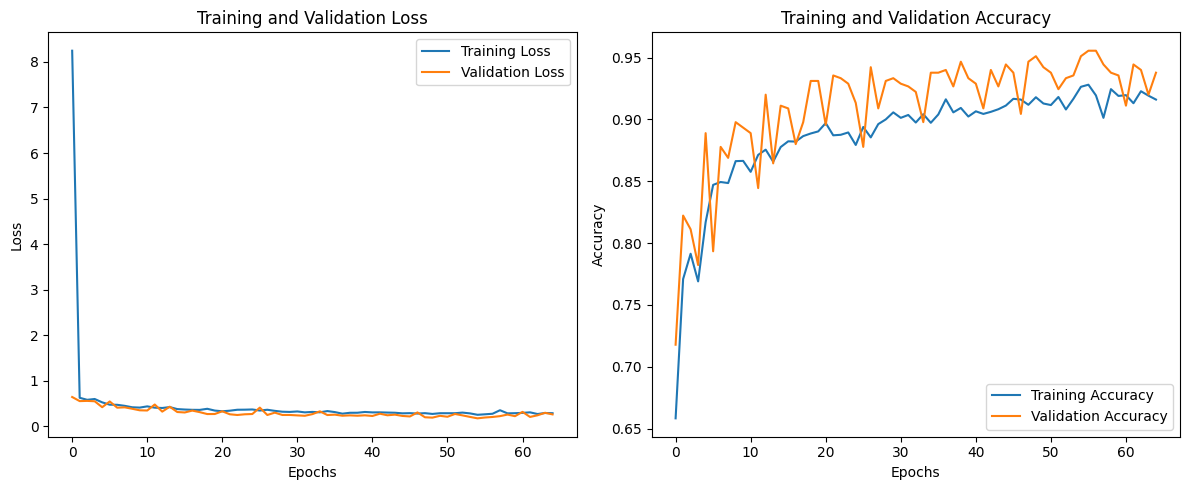

In [18]:
plot_history(history)

In [20]:
model.save('model3.h5')

In [21]:
# Memuat model terbaik dari file
import tensorflow as tf
import os
model_dir = 'model'
best_model = tf.keras.models.load_model(os.path.join(model_dir, 'best_model.keras'))

# Evaluasi model
test_loss, test_accuracy = best_model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

15/15 [==============================] - 1s 72ms/step - loss: 0.2107 - accuracy: 0.9534
Test Loss: 0.21069271862506866
Test Accuracy: 0.9534367918968201


In [ ]:
!pip install ipywidgets

   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   -------------------------- ------------- 1.6/2.3 MB 21.1 MB/s eta 0:00:01
   ------------------------------- -------- 1.8/2.3 MB 8.4 MB/s eta 0:00:01
   ----------------------------------- ---- 2.1/2.3 MB 3.9 MB/s eta 0:00:01
   ---------------------------------------- 2.3/2.3 MB 2.6 MB/s eta 0:00:00


In [22]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import load_model
from IPython.display import display
import ipywidgets as widgets
from PIL import Image
import io

# Load model
model = load_model('model/best_model.keras')  # Sesuaikan path model Anda
class_names = ['Blight', 'Common_Rust', 'Gray_leaf_Spot', 'Healthy']  # Ganti dengan nama kelas Anda

# Fungsi untuk memuat gambar dan memprosesnya
def load_and_preprocess_image(image_file, target_size=(224, 224)):
    img = Image.open(image_file).convert("RGB")  # Pastikan RGB
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0  # Normalisasi
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan batch dimensi
    return img_array

# Fungsi prediksi
def predict_image(image_file):
    img_array = load_and_preprocess_image(image_file)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]
    confidence = np.max(predictions) * 100
    return predicted_class, confidence

# Widget untuk upload gambar
upload_widget = widgets.FileUpload(accept='image/*', multiple=False)

def on_upload_change(change):
    if change['new']:
        # Ambil file pertama dari upload
        uploaded_file = next(iter(upload_widget.value.values()))  # Mengambil file pertama
        
        # Simpan konten ke dalam objek BytesIO
        image_file = io.BytesIO(uploaded_file['content'])
        
        # Tampilkan gambar
        img = Image.open(image_file)
        display(img)
        
        # Prediksi gambar
        predicted_class, confidence = predict_image(image_file)
        print(f"Predicted Class: {predicted_class}")
        print(f"Confidence: {confidence:.2f}%")

# Observasi perubahan di widget
upload_widget.observe(on_upload_change, names='value')

# Tampilkan widget
display(upload_widget)


FileUpload(value=(), accept='image/*', description='Upload')

In [ ]:
!pip install flask

In [5]:
import tensorflow as tf
model = tf.keras.models.load_model('model/best_model.keras')

In [25]:
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Sesuaikan ukuran dengan model
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan dimensi batch
    img_array /= 255.0  # Normalisasi
    return img_array

def predict_disease(img_path):
    processed_image = load_and_preprocess_image(img_path)
    predictions = model.predict(processed_image)
    
    # Print raw predictions for debugging
    print(f'Raw predictions: {predictions}')
    
    predicted_class = np.argmax(predictions, axis=1)
    return predicted_class

In [26]:
from tensorflow.keras.preprocessing import image  # If using TensorFlow 2.x
import numpy as np

img_path = r'data\Gray_Leaf_Spot\Corn_Gray_Spot (574).jpg'
predicted_class = predict_disease(img_path)
print(f'Predicted class: {predicted_class}')

1/1 [==============================] - 0s 210ms/step
Raw predictions: [[1.2032103e-16 1.0000000e+00 1.1471913e-17 3.7922326e-14]]
Predicted class: [1]


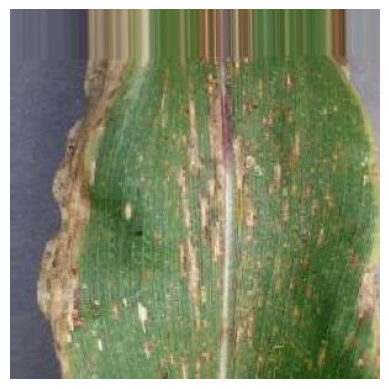

In [ ]:
import matplotlib.pyplot as plt
def display_image(img_path):
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

display_image(img_path)

In [6]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_ds, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_ds, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_ds, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

11/11 [==============================] - 1s 52ms/step - loss: 0.2163 - accuracy: 0.9489
Train Loss:  0.2208385020494461
Train Accuracy:  0.9431818127632141
--------------------
Valid Loss:  0.20041890442371368
Valid Accuracy:  0.9545454382896423
--------------------
Test Loss:  0.21632042527198792
Test Accuracy:  0.9488636255264282


ResourceExhaustedError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:Mul]